# 用Ｋ-means进行颜色量化

对圆明园的图像进行**像素矢量量化(VQ)**，将显示图像所需的颜色从96,615种减少到64种，同时保持整体外观质量。


在本例中，像素在3d空间中表示，使用K-means找到64个颜色簇。在图像处理文献中，由K-means(聚类中心)得到的码本称为调色板。使用单个字节，最多可以寻址256种颜色，而RGB编码需要每个像素3个字节。例如，GIF文件格式就使用了这样一个调色板。



In [1]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

In [2]:
n_colors = 64

# 加载圆明园的图像
china = load_sample_image("china.jpg")

# 转化为浮点数而不是默认的８位整数编码。
# 除以255是重要的这样plt.imshow在浮点数(需要在[0-1]的范围)上的表现会很好 

china = np.array(china, dtype=np.float64) / 255

# 加载图像并转化成2D的numpy数组。
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print("    done in %0.3fs." % (time() - t0))

# 获得所有点的标签
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print("    done in %0.3fs." % (time() - t0))


codebook_random = shuffle(image_array, random_state=0)[:n_colors + 1]
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random,
                                          image_array,
                                          axis=0)
print("    done in %0.3fs." % (time() - t0))


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

/home/bushuhui/.virtualenv/dl/lib/python3.5/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]
/home/bushuhui/.virtualenv/dl/lib/python3.5/site-packages/sklearn/datasets/base.py:762: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  images = [imread(filename) for filename in filenames]


Fitting model on a small sub-sample of the data
    done in 0.185s.
Predicting color indices on the full image (k-means)
    done in 0.128s.
Predicting color indices on the full image (random)
    done in 0.095s.


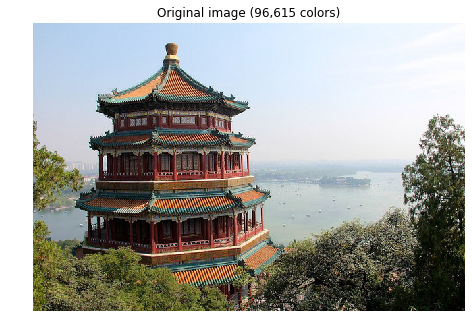

In [3]:
# 画出原始图像
plt.figure(1)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Original image (96,615 colors)')
plt.imshow(china)

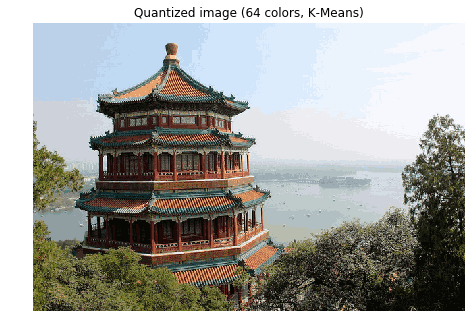

In [4]:
# 64 VQ 图像
plt.figure(2)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (64 colors, K-Means)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

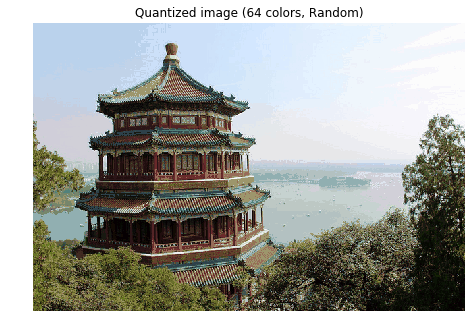

In [5]:
# 随机VQ图像
plt.figure(3)
plt.clf()
ax = plt.axes([0, 0, 1, 1])
plt.axis('off')
plt.title('Quantized image (64 colors, Random)')
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()